# COGS 108 - Final Project (change this to your project's title)

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [  ] YES - make available
* [X] NO - keep private

# Overview

We wanted to find a relationship between stimulus checks and covid infection rates across all the counties in California. We took data from all the covid infection rates by county and ran a 1 sample z-test on the before and after effects of the stimulus checks. We found that there was a significant decrease in covid rates after the stimulus checks were given, but this is not sufficient enough to say if there is a relationship. 

# Names

- David Em-Yinn
- Jing Li
- Anna Hsieh
- Alejandro Garcia Martinez
- Christian Gonzalez

<a id='research_question'></a>
# Research Question

*Is there a relationship between stimulus checks and covid infection rates across the counties of California between March 2020 to February 2021?*

<a id='background'></a>

## Background & Prior Work

### INTRO:
*The Covid-19 pandemic has had a significant negative impact on the economy, with many people losing their jobs. Similar to previous recessions, the US government provided stimulus checks in hopes of boosting the economy and also assisting people with buying protective equipment, such as masks and disinfectants. In our study, we are trying to determine whether the stimulus checks have had a positive effect (negative correlation) on covid infection rates.* 

### PRIOR WORK:
*There are few studies on the effects of the government grants that relate to covid infection rates; however, there is an article about an increase in isolation and compliance due to government grants. In 2020, a survey was conducted where they asked Americans if they would comply with an extension of stay-at-home orders. They found that about half of Americans would comply and a third wouldn’t. Moreover, they discovered that economically secure people are more likely to stay at home in isolation, while those who aren’t secure would be less likely to stay home because they had to go to work. Since the government passed 3 COVID-19 stimulus checks, along with unemployment benefits from the CARE Act, people felt more financially secure, thus more likely to stay in isolation.*

References (include links):
- 1) https://www.usa.gov/covid-stimulus-checks
- 2) https://www.nature.com/articles/s41598-020-75640-2
- 3) https://www.washingtonpost.com/politics/2020/11/19/stimulus-funds-really-do-keep-people-home-our-research-finds/

# Hypothesis


*Upon our research, we hypothesized that there is a negative correlation between the stimulus checks and covid infections rates across the counties of California. We believe this is the case because people will be able to support some of their bare necessities while staying isolated which will keep others safe and prevent exposure.*

# Dataset(s)

- Dataset Name: Statewide COVID-19 Cases Deaths Tests
- Link to the dataset: https://data.chhs.ca.gov/dataset/covid-19-time-series-metrics-by-county-and-state/resource/046cdd2b-31e5-4d34-9ed3-b48cdbc4be7a
- Number of observations: 45201

This dataset includes the number of daily COVID-19 cases, deaths, and tests for each county in California from 2/1/2020 to now as well as the population size of each county.

- Dataset Name: Stimulus Check Data
- Link to data: 
   - First round stimulus check: https://www.irs.gov/pub/irs-utl/e-poster_payments.pdf
   - Second round stimulus check: https://www.irs.gov/newsroom/treasury-and-irs-begin-delivering-second-round-of-economic-impact-payments-to-millions-of-americans
- Number of observations: N/A

We created this dataset from the IRS regarding how much families would get based on this household. The purpose of this dataset is for the reader to understand the amount of money that was disbursed. 

# Setup

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates
from datetime import datetime
from statsmodels.stats.weightstats import ztest as ztest

# Data Cleaning

### Data Set 1: Covid Rates by County
---

We first checked the unique values in the area column to find that it also included California, out of state, and unknown, so we removed those columns. Then we added a new column for the positivity rate by calculating it from the number of positive tests and the number of total tests. We only need the daily rates by county, so we selected the columns 'date', 'area', and 'rate' and renamed 'area' to 'county'. Lastly, we filtered the data to only include data from March 2020 to February 2021.

In [3]:
covid_df = pd.read_csv('https://data.chhs.ca.gov/dataset/f333528b-4d38-4814-bebb-12db1f10f535/resource/046cdd2b-31e5-4d34-9ed3-b48cdbc4be7a/download/covid19cases_test.csv')
covid_df = covid_df[~covid_df.area.isin(['California', 'Out of state', 'Unknown'])]
covid_df = covid_df.assign(rate = covid_df['positive_tests'] / covid_df['total_tests'] * 100)
covid_df = covid_df[['date', 'area', 'rate']]
covid_df = covid_df.rename({'area':'county'}, axis='columns')
covid_df = covid_df.loc[(covid_df['date'] >= '2020-03-01') & (covid_df['date'] <= '2021-02-27')]
covid_df = covid_df.reset_index()
covid_df = covid_df.drop(columns=['index'])
covid_df['date'] = pd.to_datetime(covid_df['date'], format='%Y-%m-%d')
covid_df = covid_df.dropna()
covid_df

,date,county,rate
0,2020-03-01,Alameda,0.000000
1,2020-03-02,Alameda,0.000000
2,2020-03-03,Alameda,0.000000
3,2020-03-04,Alameda,4.545455
4,2020-03-05,Alameda,0.000000
...,...,...,...
21107,2021-02-23,Yuba,1.824818
21108,2021-02-24,Yuba,7.070707
21109,2021-02-25,Yuba,6.572770
21110,2021-02-26,Yuba,5.405405


### Data Set 2: Stimulus Check Amounts
---

In order to create the data for the stimulus check, we were able to find all the data needed online [Stimulus Check 1 Source](https://www.irs.gov/pub/irs-utl/e-poster_payments.pdf) and [Stimulus Check 2 Source](https://www.irs.gov/newsroom/treasury-and-irs-begin-delivering-second-round-of-economic-impact-payments-to-millions-of-americans). We created a data frame that has two rows for the two stimulus checks we will be comparing. 

In the columns, we included the range of the disbursement dates, the base amount, amount given to a married couple, additional amount, and a the amounts that were given to families depending on how many qualified dependents or children they have in the form of tuples (x, y) where x represents a single parent family and y is a married couple family. 

The purpose of this data is for the reader to be able to see what the stimulus checks are, and how much was given to families. 

In [4]:
stimulus_data = {
    'range of disbursement': ['April 2020 - June 2020', 'December 2020 - January 2021'],
    'base': [1200, 600],
    'married couple': [2400, 1200],
    'amount per additional dependent': [500, 600],
    'one dependent': [(1700, 2900), (1200, 1800)],
    'two dependents': [(2200, 3400), (1800, 2400)],
    'three dependents': [(2700, 3900), (2400, 3000)],
    'four dependents': [(3200, 4400), (3000, 3600)],
    'five dependents': [(3700, 4900), (3600, 4200)],
    'six dependents': [(4200, 5400), (4200, 4800)]
}
stimulus_df = pd.DataFrame(stimulus_data, index = ['Stimulus Check 1', 'Stimulus Check 2'])
stimulus_df.head()

,range of disbursement,base,married couple,amount per additional dependent,one dependent,two dependents,three dependents,four dependents,five dependents,six dependents
Stimulus Check 1,April 2020 - June 2020,1200,2400,500,"(1700, 2900)","(2200, 3400)","(2700, 3900)","(3200, 4400)","(3700, 4900)","(4200, 5400)"
Stimulus Check 2,December 2020 - January 2021,600,1200,600,"(1200, 1800)","(1800, 2400)","(2400, 3000)","(3000, 3600)","(3600, 4200)","(4200, 4800)"


# Data Analysis & Results

We wanted data frames for the covid rates during from the first stimulus check and the second stimulus check. 

In [5]:
covid_df_stim1 = covid_df[(covid_df['date'] <= '2020-08-29')]
covid_df_stim2 = covid_df[(covid_df['date'] > '2020-08-29')]

(0.0, 100.0)

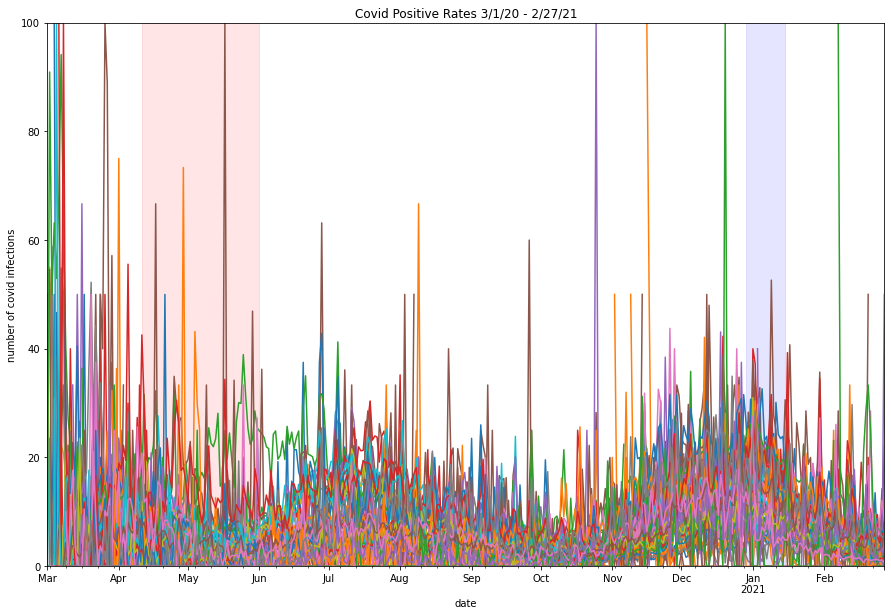

In [11]:
# We need to make this look better
ax = covid_df.pivot(index="date", columns="county", values="rate").plot(figsize=(15, 10))
ax.set_title('Covid Positive Rates 3/1/20 - 2/27/21')
ax.axvspan(dates.datestr2num('2020-04-11'), dates.datestr2num('2020-06-1'), color='red', alpha=0.1)
ax.axvspan(dates.datestr2num('2020-12-29'), dates.datestr2num('2021-01-15'), color='blue', alpha=0.1)
ax.get_legend().remove()
ax.set_ylabel('number of covid infections')
plt.ylim(0, 100)

This is a graph of all the covid infection rates amongst the counties in California from March 1, 2020 - February 27, 2021. The *red highlight* from April 11, 2020 - June 1, 2020 is when the first stimulus check was being disbursed and the *blue highlight* from December 29, 2020 - January 15, 2021 is when the second stimulus check was disburse. 

Majority of the counties seemed to follow the same trend and the spikes amongst the different counties also appear around the same time. We notice that following the disbursement of the first and second stimulus checks were a decrease in positive covid rates.

---

(0.0, 100.0)

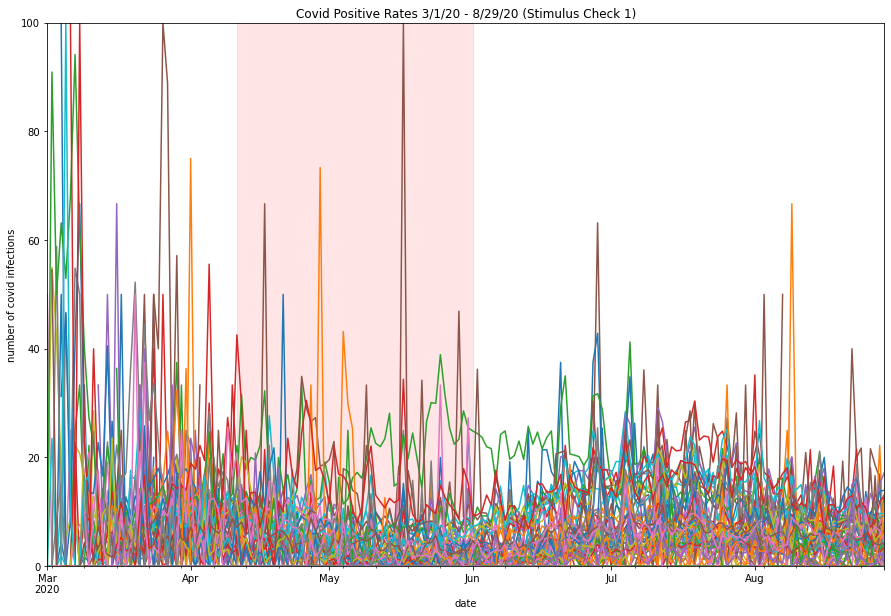

In [16]:
ax = covid_df_stim1.pivot(index="date", columns="county", values="rate").plot(figsize=(15, 10))
ax.set_title('Covid Positive Rates 3/1/20 - 8/29/20 (Stimulus Check 1)')
ax.axvspan(dates.datestr2num('2020-04-11'), dates.datestr2num('2020-06-1'), color='red', alpha=0.1)
ax.get_legend().remove()
ax.set_ylabel('number of covid infections')
plt.ylim(0, 100)

This is a graph of a subset of covid rates from March 1, 2020 - August 29, 2020. This represents the the effects of the first stimulus check on covid infection rates.

---

(0.0, 100.0)

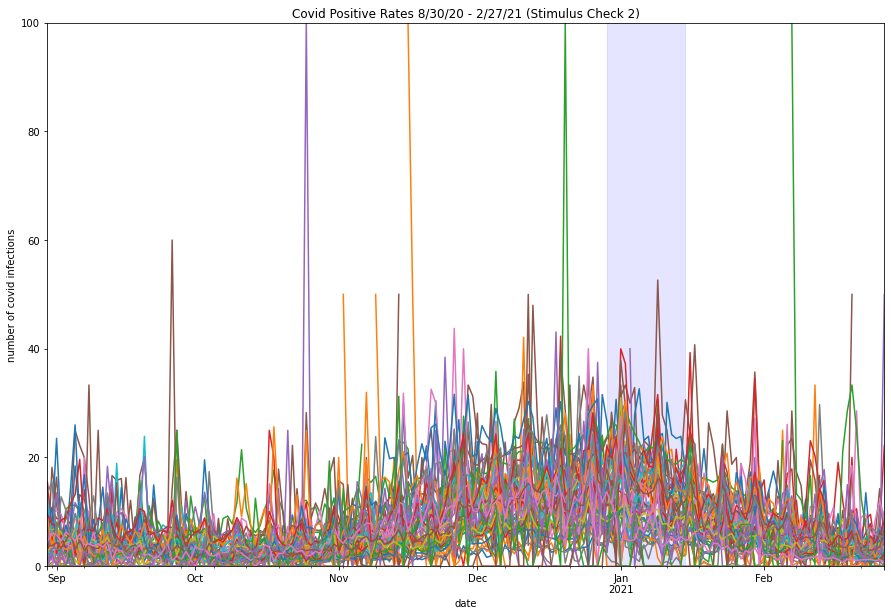

In [18]:
ax = covid_df_stim2.pivot(index="date", columns="county", values="rate").plot(figsize=(15, 10))
ax.set_title('Covid Positive Rates 8/30/20 - 2/27/21 (Stimulus Check 2)')
ax.axvspan(dates.datestr2num('2020-12-29'), dates.datestr2num('2021-01-15'), color='blue', alpha=0.1)
ax.get_legend().remove()
ax.set_ylabel('number of covid infections')
plt.ylim(0, 100)

This is a graph of a subset of covid rates from August 30, 2020 - February 27, 2021. This represents the the effects of the second stimulus check on covid infection rates.

---

We want to get the distribution of covid rates amongst all the counties a month before the stimulus check and a month after the stimulus check. 

To do this, we create 2 data frames where we have the covid infection rates a month before and a month after the first stimulus check. We do this same process for the second stimulus check. 

In [20]:
before_stim_1 = covid_df[(covid_df['date'] <= '2020-04-11') & (covid_df['date'] >= '2020-03-11')] 
before_stim_1

after_stim_1 = covid_df[(covid_df['date'] > '2020-04-11') & (covid_df['date'] <= '2020-05-11')]
after_stim_1

before_stim_2 = covid_df[(covid_df['date'] < '2020-12-29') & (covid_df['date'] >= '2020-11-29')]
after_stim_2 = covid_df[(covid_df['date'] >= '2020-12-29') & (covid_df['date'] < '2021-01-29')]

Text(0, 0.5, 'Counts')

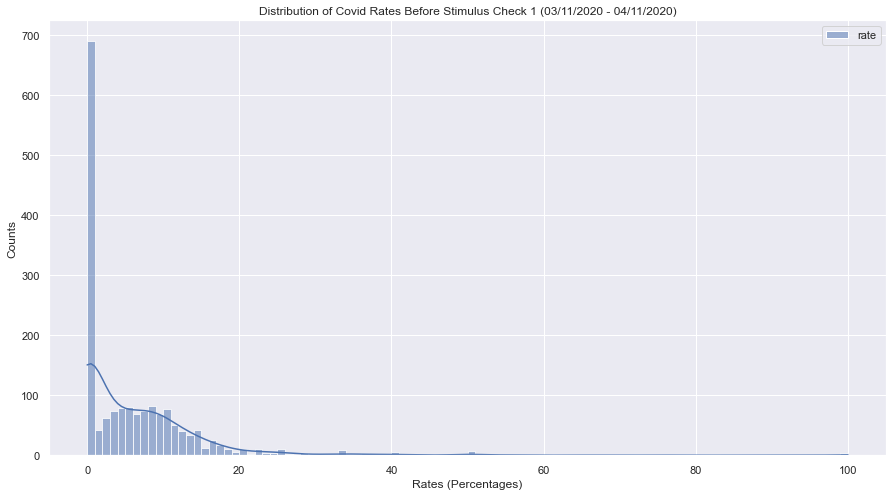

In [38]:
# Histogram before the first stim check
sns.set(rc = {'figure.figsize':(15,8)})

before_stim_1_hist = sns.histplot(before_stim_1, bins = 100, kde = True)

plt.title('Distribution of Covid Rates Before Stimulus Check 1 (03/11/2020 - 04/11/2020)')
plt.xlabel('Rates (Percentages)')
plt.ylabel('Counts')

In [37]:
before_stim_1.describe()

,rate
count,1723.000000
mean,6.253702
std,9.187371
min,0.000000
25%,0.000000
50%,3.846154
75%,9.523810
max,100.000000


Most positive covid rates were 0%, but the mean covid rates are roughly around 6.25%. We also notice that we have a lot of variance in our data which could imply we have a lot of confounds. If they were the same, we would have a smaller standard deviation. The large variance could also be due to the fact that tests were not accessible to everyone during this period. In other words, there were counties only testing people who were showing symptoms.

--- 

Text(0, 0.5, 'Counts')

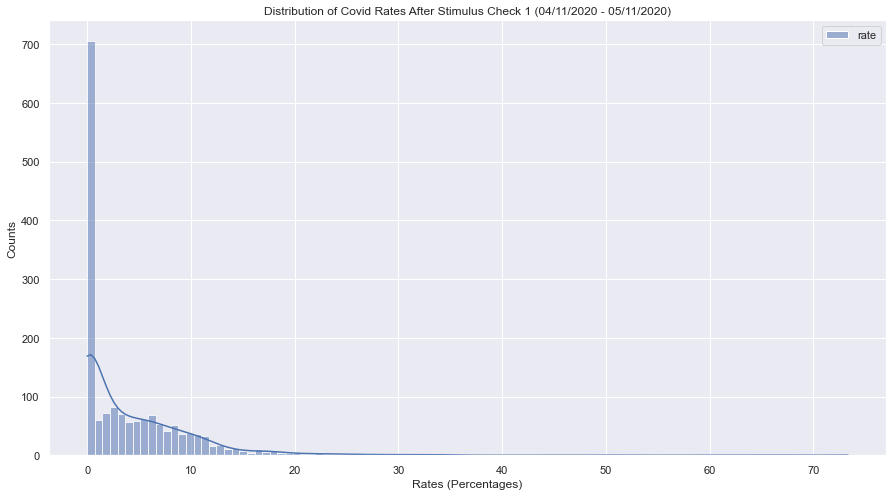

In [39]:
# Histogram after the first stim check
sns.set(rc = {'figure.figsize':(15,8)})

after_stim_1_hist = sns.histplot(after_stim_1, bins = 100, kde = True)

plt.title('Distribution of Covid Rates After Stimulus Check 1 (04/11/2020 - 05/11/2020)')
plt.xlabel('Rates (Percentages)')
plt.ylabel('Counts')

In [40]:
after_stim_1.describe()

,rate
count,1661.000000
mean,4.261862
std,6.080796
min,0.000000
25%,0.000000
50%,2.083333
75%,6.707317
max,73.333333


Here we see that after the first stimulus check, the mean covid infection rates went from 6.25% to 4.26% which *could* imply that there was a decrease in covid infection rates due to the stimulus check. We also note that the standard deviation decreased from 9.18% to 6.08%.

---

Text(0, 0.5, 'Counts')

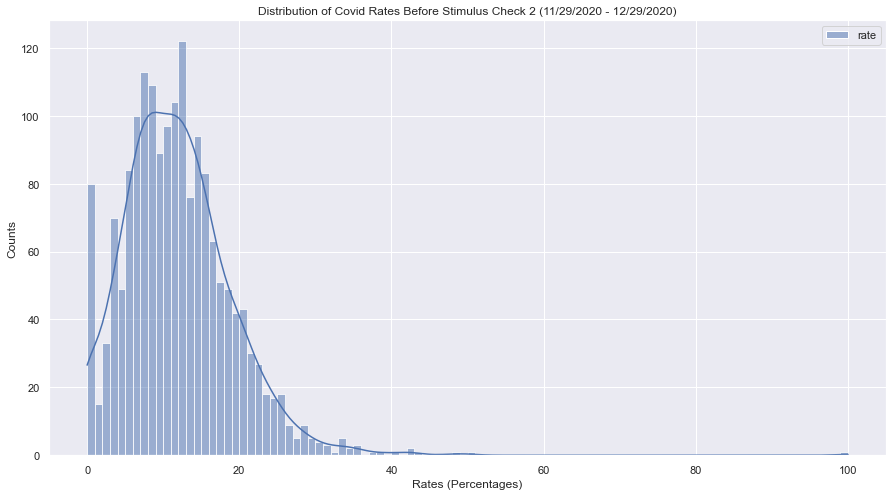

In [41]:
# Histogram before the second stim check
sns.set(rc = {'figure.figsize':(15,8)})

before_stim_2_hist = sns.histplot(before_stim_2, bins = 100, kde = True)

plt.title('Distribution of Covid Rates Before Stimulus Check 2 (11/29/2020 - 12/29/2020)')
plt.xlabel('Rates (Percentages)')
plt.ylabel('Counts')

In [42]:
before_stim_2.describe()

,rate
count,1731.000000
mean,11.911002
std,7.267613
min,0.000000
25%,7.017074
50%,11.203917
75%,15.810544
max,100.000000


During this time period which is approximately 6 months later, we see that the mean covid rate increased to 11.91% as well as an slight increase in the standard deviation being 7.26%. This *could* be that people might have ran out of their stimulus money, so covid rates *potentially* increased in that 6 month period; however, this could be a confounding variable (discussed in conclusion). 

Text(0, 0.5, 'Counts')

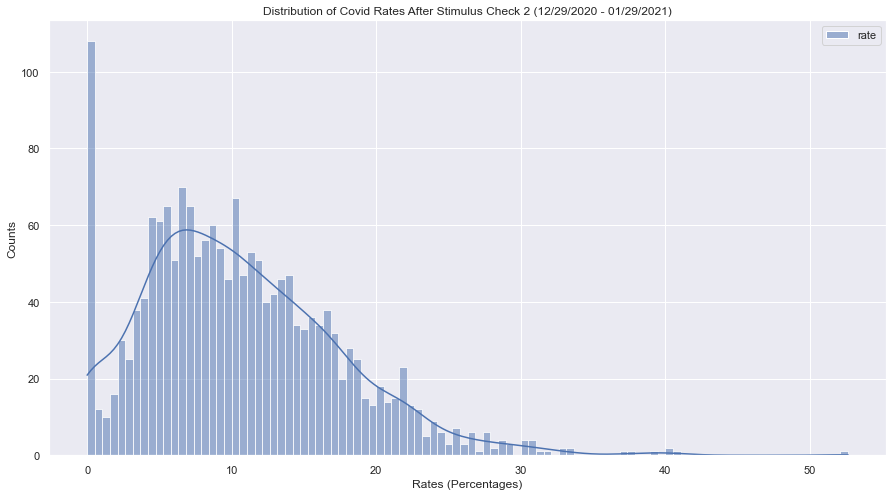

In [43]:
# Histogram after the second stim check
sns.set(rc = {'figure.figsize':(15,8)})

after_stim_2_hist = sns.histplot(after_stim_2, bins = 100, kde = True)

plt.title('Distribution of Covid Rates After Stimulus Check 2 (12/29/2020 - 01/29/2021)')
plt.xlabel('Rates (Percentages)')
plt.ylabel('Counts')

In [44]:
after_stim_2.describe()

,rate
count,1794.000000
mean,10.601698
std,6.809882
min,0.000000
25%,5.695840
50%,9.681470
75%,14.683873
max,52.631579


After the second stimulus check, we notice that the mean covid infection rate still remained high and only decreased slightly to 10.6%; however, the standard deviation decreased to 6.8% which implies the covid rates are not varying as much. In other words, the covid rates are stabilizing. The reason that covid rates might be high could be due to the holiday season which will be discussed in the conclusion section.

### Running 1 Sample Z-Test
---

We wanted to compare the means from the before and after to see if there was a change in covid infection rates. Since we are including all the counties in California, we are using the population mean instead of a sample mean. Therefore, a z-test is more appropriate than a t-test for our analysis.

Since our sample size is bigger than 30, we can assume that the distribution is approximately normal. The z-test is used to determine if there is a significant difference between the means of two groups: pre and post stimulus checks, which is appropriate for our analysis.

If the mean covid rates before the stimulus check is significantly different than the mean after the stimulus check, then this will imply that there is a relationship between covid infection rates and stimulus checks. 

If the means were the same or similiar, that would imply that the stimulus check did not have an affect on the covid infection rates, therefore we would fail to reject the null hypothesis. 

### We are running the 1 sample z-test on the the before and after covid rates of the first stimulus check. 

In [17]:
before_stim_1_rates = np.array(before_stim_1['rate'])
before_stim_1_rates

after_stim_1_rates = np.array(after_stim_1['rate'])
test_stat_1, p_val_1 = ztest(after_stim_1_rates, value = np.mean(before_stim_1_rates))
print('z test: ', test_stat_1)
print('p value: ', p_val_1)

z test:  -13.349763626402222
p value:  1.1882536432262531e-40


We see the p-value is << 0.05 which means we reject our null hypothesis. This implies that there is a relationship between covid rates and stimulus checks.

We see that this is 13 standard deviations below the mean the covid rates after the first stimulus checks which means there is was a decrease in covid rates after the first stimulus check. 

---

### We now want to run the same test with the second stimulus check

In [18]:
before_stim_2_rates = np.array(before_stim_2['rate'])
before_stim_2_rates

after_stim_2_rates = np.array(after_stim_2['rate'])
test_stat_2, p_val_2 = ztest(after_stim_2_rates, value = np.mean(before_stim_2_rates))
print('z test: ', test_stat_2)
print('p value: ', p_val_2)

z test:  -8.139740413217268
p value:  3.96126280697044e-16


We again see the p-value is << 0.05 which means we reject our null hypothesis. This also implies that there is a relationship between covid rates and stimulus checks.

We see that this is 8 standard deviations below the mean the covid rates after the second stimulus check which means there is was a decrease in covid rates after it was given. 

# Ethics & Privacy

1. Are there any biases/privacy/terms of use issues with the data you proposed?
    - There is a subset of the population who will not show up to the hospital or take a covid test so there is a set of people whose covid data isn’t available.
2. Are there potential biases in your dataset(s), in terms of who it composes, and how it was collected, that may be problematic in terms of it allowing for equitable analysis? (For example, does your data exclude particular populations, or is it likely to reflect particular human biases in a way that could be a problem?)
    - Our sample size leaves room for a lot of confounds including class, cultural, and geographical differences. While covid infections are unbiased, healthcare access, necessity for work and government/science (People) (Science/Government Distrust creates anti-science culture: Polio vaccine, fake studies on the biological difference of black people) are all variables that are difficult to account for. Because of this, we will most likely fail to come up with solutions on how to reduce covid rates in these communities despite not being deserving of higher covid rates.
3. How will you set out to detect these specific biases before, during, and after/when communicating your analysis?
    - Reducing area to reduce cultural/political differences such that we can accurately assess the left over variables (We assume the leftovers will mainly be geographical variables). 
4. Are there any other issues related to your topic area, data, and/or analyses that are potentially problematic in terms of data privacy and equitable impact?
    - Participants might not agree with how the original data was collected (Via government resources). They might extend their distrust with the government/historical science onto us making it harder to apply our results (Assuming they’re meaningful).
5. How will you handle issues you identified?
    - Still unsure.


# Conclusion & Discussion

- Why we couldn't run other tests 
    - why we couldn't do correlation
    - why we couldn't do inferential (idk how to spell...)
    - why we couldn't do *insert test* 
- Confounds
    - Pandemic is really unpredictable 
    - Different variances
    - The second stim check, the first covid shot was released --> did rates do down because of stim or vacc? 
    - After the first stim check, we were put on lock down for the next 6-8 months, so did rates go down because of stim or quarantine? 
    - First stim check was the start of the first lock down (mar 19 2020) around the same time as our stim check
    - People used their stim checks differently some used on food, family needs, others might have used it for other things like building new computers
    - Holidays, how many people were ACTUALLY quarantining during the holidays? were people going out a lot during the later part of the lock down? 
    - People got tired of lock down in the later half
- Data set issues (couldn't find the right data sets) 
    - We wanted costs of living on counties 
        - intended to group by people and groups based on costs of living. The same amt of money in one county could be less/more impactful than another county. 
    - Total amount of money each county got 
        - potentially could have helped for sampling purposes. Compare other other counties
    - First idea was to compare amount of stimulus money amongst different groups, but everyone got the same amount of money, so this data set didn't exist. 
    - Overall, we lacked a lot of resources to run different tests and analysis. Having more variety of data sets would have potentially help with confounding variables, but since we didn't have them, we will never really know how our analysis and results would have looked like. 
- More on the results (even though our z test implied that there is a relationship -> doesn't mean there is)
    - Even though our results from our z test implied that there is a relationship, this doesn't mean there is because there are a lot of confounding variables specified above. 

# Team Contributions

*Specify who in your group worked on which parts of the project.*